## Step 1 – Setup and load processed datasets
Define the processed-data folder and read the three CSVs created in the dataloading notebook:  
- `Zc_monthly_occupancy_2010_2018.csv` (ZC occupancy by site×month)  
- `env_drivers_pivot_2010_2018.csv` (monthly eReefs drivers, wide)  
- `Zc_occ_with_env_2010_2018.csv` (merged occupancy + drivers + lags)  
Parse dates, confirm shapes, and collect the canonical site list for plotting.


In [1]:
#Cell 1 — Setup & load processed data
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# CHANGE this to your processed folder
DATA = Path(r"C:\Users\F\Desktop\ENVI5809\data for analysis\processed")
assert DATA.exists(), f"Folder not found: {DATA}"

occ    = pd.read_csv(DATA / "Zc_monthly_occupancy_2010_2018.csv", parse_dates=["date"])
envw   = pd.read_csv(DATA / "env_drivers_pivot_2010_2018.csv", parse_dates=["date"])
merged = pd.read_csv(DATA / "Zc_occ_with_env_2010_2018.csv", parse_dates=["date"])

sites  = merged["SURVEY_NAM"].unique().tolist()
print("Loaded:", occ.shape, envw.shape, merged.shape, "| Sites:", sites)

Loaded: (112, 8) (800, 11) (112, 36) | Sites: ['Abbot_Point', 'Cairns', 'Clairview', 'Gladstone', 'HayPoint', 'Mourilyan', 'OSRA', 'Townsville']


## Step 2 – Rescue cell: reload processed data safely  
Use this fallback cell if the main data path is missing or the notebook is opened elsewhere.  
It defines `DATA`, verifies the existence of all three processed files, and reloads them with date parsing.  
Ensures that `occ`, `envw`, and `merged` DataFrames are available and consistent before any spatial-temporal analysis.


In [2]:
# Rescue Cell — define DATA and (re)load the processed CSVs
import pandas as pd
from pathlib import Path

# 👉 set your processed folder here
DATA = Path(r"C:\Users\F\Desktop\ENVI5809\data for analysis\processed")

# fallback: try a local "processed" folder next to the notebook
if not DATA.exists():
    DATA = Path.cwd() / "processed"

occ_path    = DATA / "Zc_monthly_occupancy_2010_2018.csv"
envw_path   = DATA / "env_drivers_pivot_2010_2018.csv"
merged_path = DATA / "Zc_occ_with_env_2010_2018.csv"

for p in [occ_path, envw_path, merged_path]:
    assert p.exists(), f"Missing file: {p}"

occ    = pd.read_csv(occ_path, parse_dates=["date"])
envw   = pd.read_csv(envw_path, parse_dates=["date"])
merged = pd.read_csv(merged_path, parse_dates=["date"])

print("Loaded → occ:", occ.shape, "| envw:", envw.shape, "| merged:", merged.shape)

Loaded → occ: (112, 8) | envw: (800, 11) | merged: (112, 36)


## Step 3 – Site × month heatmap of Z. capricorni occupancy  
Pivot the merged dataset to create a site (rows) × month (columns) matrix of mean occupancy `p`.  
Plot the matrix as a heatmap using `imshow` to visualize temporal variation in occupancy across sites and years.  
Axis ticks show sites on the y-axis and unique years on the x-axis, and a colorbar indicates occupancy fraction.  
The figure is saved as `fig_heatmap_occupancy.png` in the output folder.


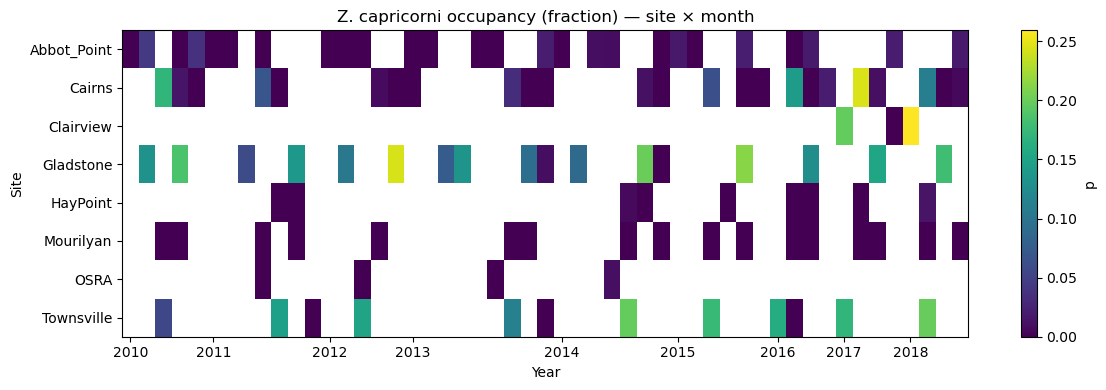

In [5]:
heat = merged.pivot_table(index="SURVEY_NAM", columns="date", values="p", aggfunc="mean")

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect="auto", interpolation="nearest")
plt.yticks(range(len(heat.index)), heat.index)
years = pd.to_datetime(heat.columns).year
xticks = [i for i,y in enumerate(years) if i==0 or years[i-1]!=y]
plt.xticks(xticks, [str(years[i]) for i in xticks])
plt.title("Z. capricorni occupancy (fraction) — site × month")
plt.xlabel("Year"); plt.ylabel("Site")
plt.colorbar(label="p")
plt.tight_layout()

from pathlib import Path
OUT = Path(".")  # or Path("./figures")
OUT.mkdir(exist_ok=True)
plt.savefig(OUT / "fig_heatmap_occupancy.png", dpi=300)
plt.show()

## Step 4 – Seasonal cycle of Z. capricorni occupancy (2010–2018)  
Compute the monthly climatology of occupancy by grouping all years by calendar month.  
Calculate mean, standard deviation, and standard error to describe the seasonal pattern.  
Plot the mean monthly occupancy with a shaded ±SE band to visualize intra-annual variability.  
Save the figure as `fig_seasonal_cycle.png` in the output folder.


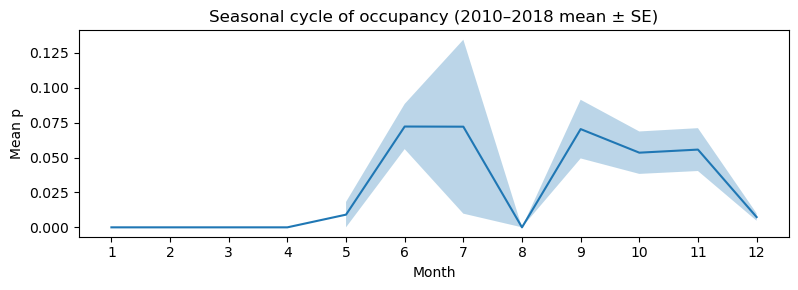

In [6]:
occ2 = occ.copy()
occ2["month"] = occ2["date"].dt.month
clim = occ2.groupby("month")["p"].agg(["mean","std","count"]).reset_index()
clim["se"] = clim["std"] / np.sqrt(clim["count"].clip(lower=1))

plt.figure(figsize=(8,3))
plt.plot(clim["month"].values, clim["mean"].values)
plt.fill_between(clim["month"].values,
                 (clim["mean"]-clim["se"]).values,
                 (clim["mean"]+clim["se"]).values, alpha=0.3)
plt.title("Seasonal cycle of occupancy (2010–2018 mean ± SE)")
plt.xlabel("Month"); plt.ylabel("Mean p"); plt.xticks(range(1,13))
plt.tight_layout()

from pathlib import Path
OUT = Path(".")  # or Path("./figures")
OUT.mkdir(exist_ok=True)
plt.savefig(OUT / "fig_seasonal_cycle.png", dpi=300)
plt.show()


## Step 5 – Per-site time series with 95% CIs
Define a helper to plot each site’s monthly occupancy with Wilson 95% CI bands.  
Loop over all sites, sort by date, and export one PNG per site to the output folder.  
This highlights interannual variability and uncertainty at site level for 2010–2018.


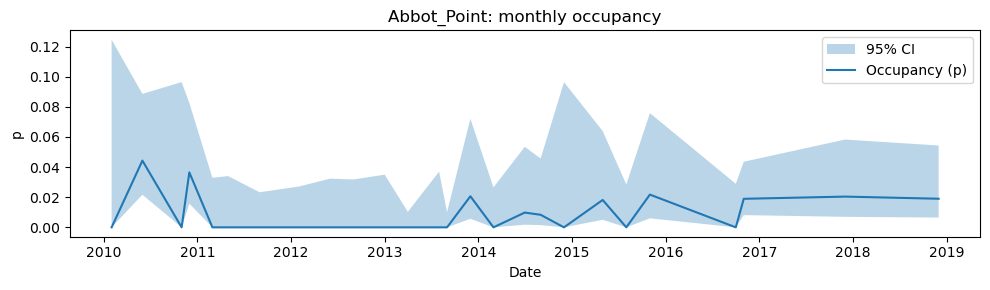

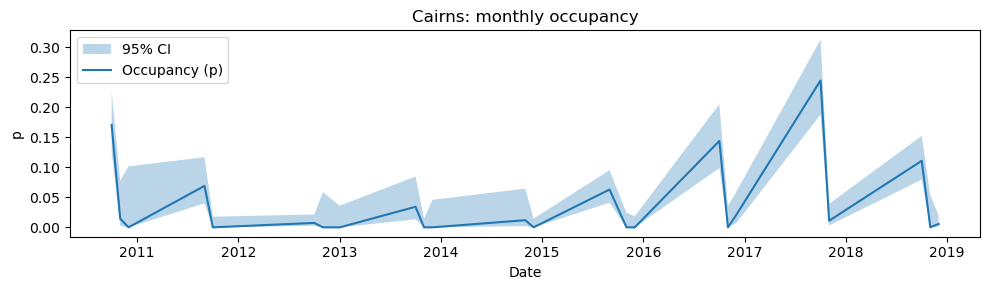

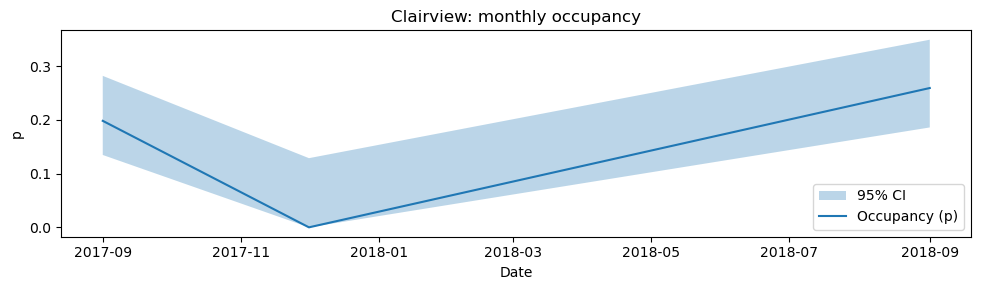

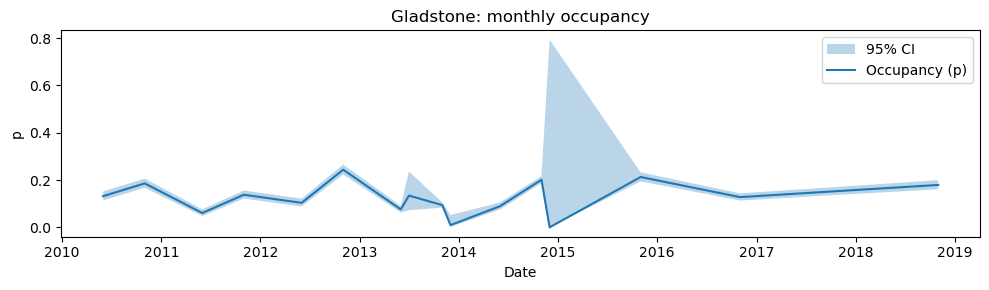

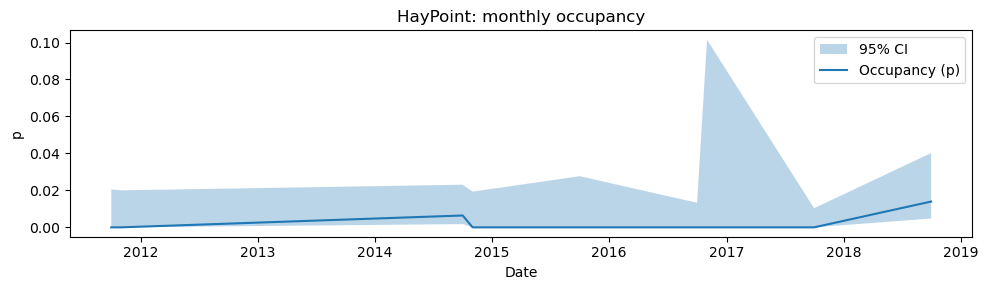

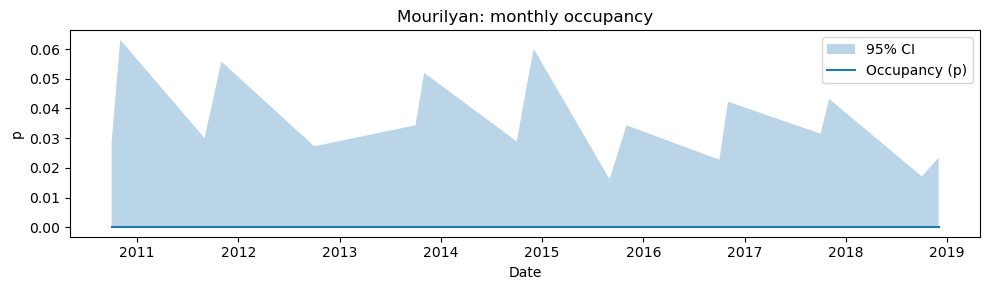

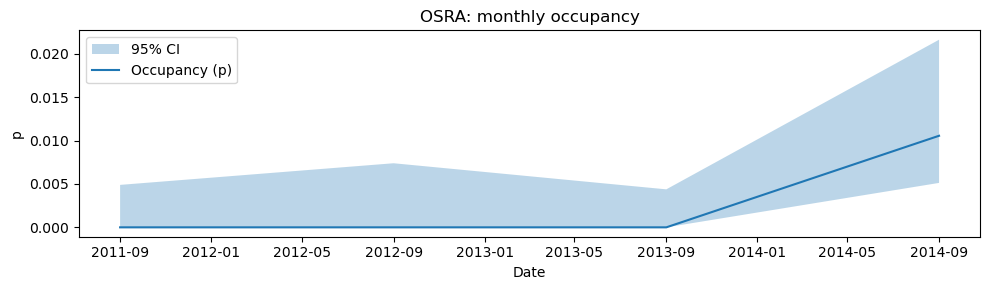

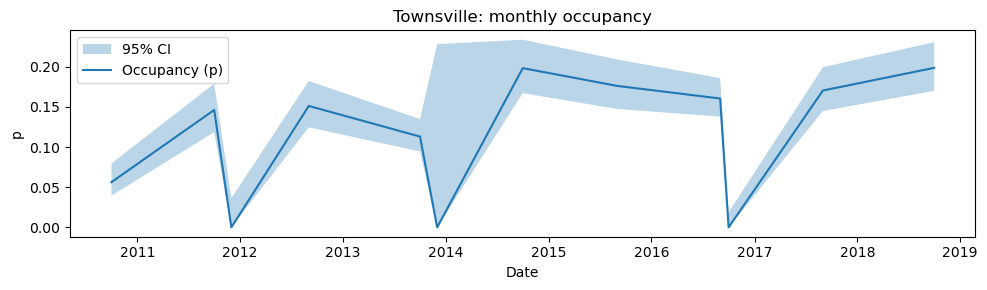

Saved per-site time series to: .


In [7]:
def plot_site_series(site):
    df = occ[occ["SURVEY_NAM"]==site].sort_values("date")
    plt.figure(figsize=(10,3))
    plt.fill_between(df["date"], df["p_lo"], df["p_hi"], alpha=0.3, label="95% CI")
    plt.plot(df["date"], df["p"], label="Occupancy (p)")
    plt.title(f"{site}: monthly occupancy")
    plt.xlabel("Date"); plt.ylabel("p"); plt.legend()
    plt.tight_layout()
    plt.savefig(OUT / f"fig_timeseries_{site}.png", dpi=300)
    plt.show()

for s in sorted(occ["SURVEY_NAM"].unique()):
    plot_site_series(s)
print("Saved per-site time series to:", OUT)

## Step 6 – Correlation among environmental drivers
Select available driver columns and compute a Pearson correlation matrix.  
Visualize the matrix with a heatmap to identify collinearity among `temp`, `salt`, `eta`, currents, and wind metrics.  
Use this to flag redundant predictors before GLM/SARIMAX/ML modeling.  
Figure saved as `fig_driver_corr.png`.


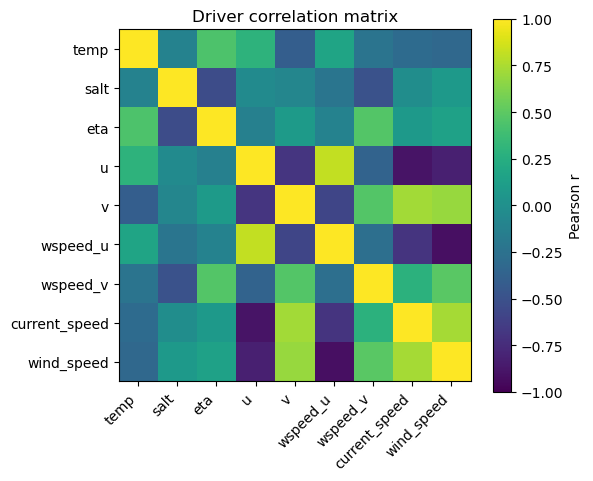

In [8]:
driver_cols = [c for c in ["temp","salt","eta","u","v","wspeed_u","wspeed_v","current_speed","wind_speed"]
               if c in merged.columns]
corr = merged[driver_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
plt.xticks(range(len(driver_cols)), driver_cols, rotation=45, ha="right")
plt.yticks(range(len(driver_cols)), driver_cols)
plt.colorbar(label="Pearson r")
plt.title("Driver correlation matrix")
plt.tight_layout()
plt.savefig(OUT / "fig_driver_corr.png", dpi=300)
plt.show()